In [1]:
import numpy as np
import scipy as sp

import matplotlib.pyplot as plt
import matplotlib.axes as axe
import pandas as pd
import datetime as dt
import gurobipy as gp
from gurobipy import GRB
import cvxpy as cp

import copy

import random
from itertools import chain, combinations, tee
import time

import math

plt.rcParams['text.usetex'] = True

# Functions

In [2]:
def demand_name_by_group_index(index):
    list_demand_names = ["Demand (eligible group, 1)", "Demand (eligible group, 2)", \
                         "Demand (ineligible group, 1)", "Demand (ineligible group, 2)", \
                         "Demand (ineligible group, 3)"]
    return list_demand_names[index]

def VoT_name_by_group_index(index):
    list_demand_names = ["VoT (eligible group, 1)", "VoT (eligible group, 2)", \
                         "VoT (ineligible group, 1)", "VoT (ineligible group, 2)", \
                         "VoT (ineligible group, 3)"]
    return list_demand_names[index]

def equals(a, b, tol = 1E-3):
    if abs(a-b) <= tol:
        return True
    else:
        return False
    
def equals_array(arr_1, arr_2, tol = 1E-2):
    if np.linalg.norm(arr_1 - arr_2) <= tol:
        return True
    else:
        return False
    

In [3]:
def latency_max(flow_max, coeff):
    
    assert np.all(coeff >= 0.0), "coeff should be non-negative"
    assert len(coeff.shape) == 1, "coeff should be a 1-D array."
    assert coeff.shape[0] == 3, "Latency functions are assumed to be piecewise linear / affine with 3 parameters."
    
    return coeff[0] + max(coeff[1] * (flow_max - coeff[2]), 0)

In [4]:
def round_to_sig_figs(number, sig_figs):
    if number == 0:
        return 0.0
    
    # Calculate the exponent for scientific notation
    exponent = math.floor(math.log10(abs(number)))
    
    # Calculate the scaling factor to bring the number to a single digit before the decimal
    scale = 10**(sig_figs - 1 - exponent)
    
    # Scale, round, and then unscale
    rounded_number = round(number * scale) / scale
    
    return rounded_number

def round_to_sig_figs_array_1D(arr, sig_figs):
    
    arr_rounded = np.zeros(arr.shape)
    
    for i in range(arr.shape[0]):
        arr_rounded[i] = round_to_sig_figs(arr[i], sig_figs)
            
    return arr_rounded

def round_to_sig_figs_array_2D(arr, sig_figs):
    
    arr_rounded = np.zeros(arr.shape)
    
    for i in range(arr.shape[0]):
        for j in range(arr.shape[1]):
            arr_rounded[i, j] = round_to_sig_figs(arr[i, j], sig_figs)
            
    return arr_rounded

In [5]:
# arr_1 = np.array([[1, 2, 3], [4, 5, 6]])
# np.linalg.norm(arr_1)

# Download Groups, Routes to Edges Data:

In [6]:
directory_path = '../data/data_income_percentage_VoT___101_N_Sep_to_Nov_2024/'
# df_data = pd.read_csv(directory_path + 'data_cities_od_VoTs_demands_1.csv')
df_data = pd.read_csv(directory_path + 'data_cities_od_VoTs_demands_3.csv')

# df_od_flow_data
# df_data

In [7]:
dict_data = {}

for column_name_full in list(df_data.columns):
    if column_name_full == "Data Category":
        categories_list = df_data[column_name_full].tolist()
    else:
        dict_data[int(column_name_full)] = {}
        for category_index, category in enumerate(categories_list):
            if category == "Start City Index" or category == "End City Index":
                dict_data[int(column_name_full)][category] \
                    = int(df_data[column_name_full].tolist()[category_index])
            elif category == "Start City" or category == "End City":
                dict_data[int(column_name_full)][category] \
                    = df_data[column_name_full].tolist()[category_index]
            else:
#                 print("category:", category)
                dict_data[int(column_name_full)][category] \
                    = float(df_data[column_name_full].tolist()[category_index])

# Test git

In [8]:
dict_data

{0: {'Start City Index': 0,
  'End City Index': 0,
  'Start City': 'Palo Alto',
  'End City': 'Palo Alto',
  'O-D Flow (Max Entropy)': 612.5396169,
  'Demand (eligible group, 1)': 60.02888246,
  'VoT (eligible group, 1)': 0.041801576,
  'Demand (eligible group, 2)': 36.75237701,
  'VoT (eligible group, 2)': 0.149405716,
  'Demand (ineligible group, 1)': 93.71856139,
  'VoT (ineligible group, 1)': 0.299498806,
  'Demand (ineligible group, 2)': 134.7587157,
  'VoT (ineligible group, 2)': 0.580929487,
  'Demand (ineligible group, 3)': 287.2810803,
  'VoT (ineligible group, 3)': 1.859644942},
 1: {'Start City Index': 0,
  'End City Index': 1,
  'Start City': 'Palo Alto',
  'End City': 'East Palo Alto',
  'O-D Flow (Max Entropy)': 98.03491986,
  'Demand (eligible group, 1)': 9.607422146,
  'VoT (eligible group, 1)': 0.041801576,
  'Demand (eligible group, 2)': 5.882095192,
  'VoT (eligible group, 2)': 0.149405716,
  'Demand (ineligible group, 1)': 14.99934274,
  'VoT (ineligible group, 1)':

In [9]:
cities_dict = {}
for od_info in list(dict_data.values()):
    if od_info["Start City Index"] not in list(cities_dict.keys()):
        cities_dict[od_info["Start City Index"]] = od_info["Start City"]
    if od_info["End City Index"] not in list(cities_dict.keys()):
        cities_dict[od_info["End City Index"]] = od_info["End City"]

cities_list = list(cities_dict.values())

# cities_dict

In [10]:
od_to_edges_array = np.zeros((len(list(dict_data.keys())), 2))

for od_index, od_info in dict_data.items():
    od_to_edges_array[od_index, 0] = int(cities_list.index(od_info["Start City"]))
    od_to_edges_array[od_index, 1] = int(cities_list.index(od_info["End City"]))

edge_to_od_dict = {}
num_edges = int(np.max(od_to_edges_array)) + 1
# print("num_edges:", num_edges)

for e in range(num_edges):
    edge_to_od_dict[e] = [k for k in list(range(int(od_to_edges_array.shape[0]) )) \
                           if od_to_edges_array[k, 0] <= e <= od_to_edges_array[k, 1]]
    
# od_to_edges_array
# edge_to_od_dict

In [11]:
num_groups_per_od = 5

demand_array = np.zeros((len(list(dict_data.keys())), num_groups_per_od))
VoT_array_base = np.zeros((len(list(dict_data.keys())), num_groups_per_od))

for od_index, od_value in dict_data.items():
    for group_index in range(num_groups_per_od):
        demand_name = demand_name_by_group_index(group_index)
        VoT_name = VoT_name_by_group_index(group_index)
        
        demand_array[od_index, group_index] = od_value[demand_name]
        VoT_array_base[od_index, group_index] = od_value[VoT_name]

print(demand_array)
# VoT_array_base

[[ 60.02888246  36.75237701  93.71856139 134.7587157  287.2810803 ]
 [  9.60742215   5.88209519  14.99934274  21.56768237  45.97837741]
 [111.5247907   68.28048412 174.1152345  250.3617751  533.7257842 ]
 [ 25.07588823  15.35258463  39.14909081  56.29281031 120.0060365 ]
 [ 95.06622324  58.20381015 148.4197159  213.4139705  454.9597826 ]
 [ 23.76644387  14.550884    37.10475421  53.35324134 113.73941   ]
 [150.0445053   91.86398285 234.2531563  336.8346038  718.0701326 ]
 [ 25.30172796  35.37078297  62.99613901  74.8724603   59.63978735]
 [  5.68890543   7.95285759  14.16421351  16.83451606  13.40956279]
 [ 21.56665392  30.14930191  53.6965669   63.81969017  50.83568424]
 [  5.39189555   7.5376499   13.42471953  15.95560927  12.70946808]
 [ 34.04016665  47.58676358  84.75306798 100.7311054   80.23753567]
 [ 10.40251464  13.91885761  23.5888008   37.36114412  61.2429735 ]
 [ 39.43629223  52.76686989  89.42595844 141.6373876  232.1742275 ]
 [  9.85945787  13.19223236  22.35736222  35.410

In [12]:
directory_path = '../data/data_income_percentage_VoT___101_N_Sep_to_Nov_2024/'

T = 5
VoT_array = np.zeros((VoT_array_base.shape[0], VoT_array_base.shape[1], T))

for t in range(T):
    df_perturbation_data = pd.read_csv(directory_path + 'perturbations_1_' + str(t) + '.csv')
    perturbation_array = df_perturbation_data.to_numpy()[:, 1:]
    VoT_array[:, :, t] = VoT_array_base * perturbation_array
    
# VoT_array_base
# perturbation_array

# Download Latency Parameters Data

In [13]:
directory_path_latency = '../data/pems_latency_inference___101_N_Sep_to_Nov_2024/'
df_latency_params = pd.read_csv(directory_path_latency + 'latency_params.csv')

# list(df_latency_params.loc[:, "Palo Alto"])

In [14]:
dict_latency_params = {}

city_list = list(df_latency_params.columns)[1:]

for city in city_list:
#     if city != "Belmont":
    if 1 == 1:
        dict_latency_params[city] = {}
        dict_latency_params[city]["Flow (at bend)"] = df_latency_params.loc[:, city][0]
        dict_latency_params[city]["Latency (at bend)"] = df_latency_params.loc[:, city][1]
        dict_latency_params[city]["Slope (after bend)"] = df_latency_params.loc[:, city][2]

dict_latency_params

{'Palo Alto': {'Flow (at bend)': np.float64(861.9885),
  'Latency (at bend)': np.float64(1.326448252),
  'Slope (after bend)': np.float64(0.000782666)},
 'East Palo Alto': {'Flow (at bend)': np.float64(1001.517857),
  'Latency (at bend)': np.float64(2.213126553),
  'Slope (after bend)': np.float64(0.000584484)},
 'Redwood City': {'Flow (at bend)': np.float64(881.1846667),
  'Latency (at bend)': np.float64(4.892192375),
  'Slope (after bend)': np.float64(0.001563724)},
 'Belmont': {'Flow (at bend)': np.float64(1278.948125),
  'Latency (at bend)': np.float64(1.199911179),
  'Slope (after bend)': np.float64(0.001994138)},
 'San Mateo': {'Flow (at bend)': np.float64(1034.092826),
  'Latency (at bend)': np.float64(5.541006284),
  'Slope (after bend)': np.float64(0.002147262)},
 'Burlingame': {'Flow (at bend)': np.float64(845.15),
  'Latency (at bend)': np.float64(1.503111345),
  'Slope (after bend)': np.float64(0.000306601)},
 'Millbrae': {'Flow (at bend)': np.float64(853.1818182),
  'Laten

In [15]:
# num_edges = 7
num_gp_lanes = 3

num_el = 2
num_groups = demand_array.shape[1]

el_indices = list(range(num_el))
in_indices = list(range(num_el, num_groups))

coeff_input = np.zeros((3, num_edges))
for counter, city in enumerate(dict_latency_params.keys()):
    coeff_input[0, counter] = dict_latency_params[city]["Latency (at bend)"]
    coeff_input[1, counter] = dict_latency_params[city]["Slope (after bend)"]
    coeff_input[2, counter] = dict_latency_params[city]["Flow (at bend)"]
    

In [16]:
## Set lambdas:

lambda_E, lambda_R, lambda_I = 1.0, 1.0, 1.0

## Initialize tau, alpha values:

filename_segment = str(int(lambda_E)) + '_' + str(int(lambda_R)) + '_' + str(int(lambda_I))

directory_inits = '../data/opt_CBCP_values___' + str(num_el) + '_el_groups/'
# directory_inits = '../data/opt_CBCP_values___' + str(num_el) + '_el_groups___before_20251001/'
df_inits = pd.read_csv(directory_inits + filename_segment + '___tau_B_stats_CBCP.csv')

print("filename_segment:", filename_segment)
print()

inits_tau_arr_as_object = df_inits.to_numpy()[:, 1:6]
inits_B_arr_as_object = df_inits.to_numpy()[0, 7]

argmin_tau = np.zeros((num_edges, T))
argmin_B = 0

for e in range(num_edges):
    for t in range(T):
        argmin_tau[e, t] = inits_tau_arr_as_object[e, t]
        argmin_B = inits_B_arr_as_object

print("argmin_tau:\n", argmin_tau)
print()
print("argmin_B:\n", argmin_B)


filename_segment: 1_1_1

argmin_tau:
 [[0.92 0.25 0.45 0.45 0.97]
 [0.88 0.34 0.85 0.57 0.68]
 [0.51 2.24 2.01 1.38 2.2 ]
 [1.34 0.84 1.54 1.26 2.52]
 [2.28 2.09 2.33 0.59 1.43]
 [0.48 0.48 0.68 0.5  0.39]
 [0.71 0.26 0.49 0.34 0.8 ]]

argmin_B:
 8.95


In [17]:
# argmin_tau = np.array([[0.0, 0.3194, 0.3194, 0.0, 0.0], \
#                        [0.2498, 0.2498, 0.2498, 0.0, 0.0], \
#                        [0.0, 0.0, 0.0, 0.9995, 0.9995], \
#                        [0.0, 1.0281, 1.0281, 1.0281, 0.0], \
#                        [1.6043, 0.0, 0.0, 1.6043, 0.0], \
#                        [0.0, 0.1922, 0.1922, 0.1922, 0.0], \
#                        [0.0, 0.0, 0.0, 0.2178, 0.2178]])

# argmin_B = 10.6925

# Compute CBCP and DBCP comparison statistics

In [18]:
# demand_array
# edge_to_od_dict
# od_to_edges_array

# demand_array[:, 0:3]
# demand_array[:, 3:5]
# demand_array

# np.sum(demand_array[:, 0:3], axis=1).shape

In [19]:
demand_array_el = np.sum(demand_array[:, 0:3], axis=1)
demand_array_in = np.sum(demand_array[:, 3:5], axis=1)

demand_array_el_across_edges = np.zeros(num_edges)
demand_array_in_across_edges = np.zeros(num_edges)
demand_array_across_edges = np.zeros(num_edges)

for e in range(num_edges):
    demand_array_el_across_edges[e] = np.sum([demand_array_el[od] for od in edge_to_od_dict[e]])
    demand_array_in_across_edges[e] = np.sum([demand_array_in[od] for od in edge_to_od_dict[e]])
    demand_array_across_edges[e] = demand_array_el_across_edges[e] + demand_array_in_across_edges[e]

# demand_array_el_across_edges[e]

In [20]:
## Verify that demand_array_across_edges = demand_array_el_across_edges + demand_array_in_across_edges

print("demand_array_el_across_edges:", demand_array_el_across_edges)
print("demand_array_in_across_edges:", demand_array_in_across_edges)
print("demand_array_across_edges:", demand_array_across_edges)
print()

demand_array_consistent_tolerance = 1E-2
demand_array_consistent = np.all(np.abs(demand_array_across_edges \
                                        - demand_array_el_across_edges - demand_array_in_across_edges) \
                                <= demand_array_consistent_tolerance)

print(demand_array_consistent)


demand_array_el_across_edges: [1507.76022975 1766.88182127 2298.02265612 1990.28188173 2635.79268928
 2188.02527656 2341.16466527]
demand_array_in_across_edges: [3340.34340273 3407.34902606 4495.69527418 4057.35641752 5309.06757486
 4457.04544686 4772.24643272]
demand_array_across_edges: [4848.10363248 5174.23084733 6793.7179303  6047.63829925 7944.86026414
 6645.07072342 7113.41109799]

True


In [21]:
# Read data from csv and store into numpy files

directory_CBCP = '../data/opt_CBCP_values___' + str(num_el) + '_el_groups/'
directory_DBCP = '../data/opt_DBCP_values___' + str(num_el) + '_el_groups/'
# directory_CBCP = '../data/opt_CBCP_values___' + str(num_el) + '_el_groups___before_20251001/'
# directory_DBCP = '../data/opt_DBCP_values___' + str(num_el) + '_el_groups___before_20251001/'

tau_CBCP_dict = {}
tau_time_averaged_CBCP_dict = {}
B_CBCP_dict = {}
percent_express_lane_use_CBCP_dict = {}
avg_travel_time_CBCP_dict = {}
total_costs_CBCP_dict = {}

tau_DBCP_dict = {}
tau_time_averaged_DBCP_dict = {}
alpha_DBCP_dict = {}
percent_express_lane_use_DBCP_dict = {}
avg_travel_time_DBCP_dict = {}
total_costs_DBCP_dict = {}


# lambdas_array = np.array([[1.0, 1.0, 1.0], \
#                           [1.0, 5.0, 1.0], \
#                           [1.0, 10.0, 1.0], \
#                           [5.0, 5.0, 1.0], \
#                           [5.0, 10.0, 1.0], \
#                           [10.0, 10.0, 1.0], \
#                           [1.0, 1.0, 0.0], \
#                           [1.0, 5.0, 0.0], \
#                           [5.0, 10.0, 0.0]])

lambdas_array = np.array([[1.0, 1.0, 1.0], \
                          [1.0, 5.0, 1.0], \
                          [1.0, 10.0, 1.0], \
                          [5.0, 5.0, 1.0], \
                          [5.0, 10.0, 1.0], \
                          [10.0, 10.0, 1.0], \
                          [1.0, 1.0, 0.0], \
                          [1.0, 5.0, 0.0], \
                          [5.0, 10.0, 0.0], \
                          [5.0, 1.0, 1.0], \
                          [10.0, 5.0, 1.0], \
                          [10.0, 1.0, 1.0], \
                          [20.0, 1.0, 1.0], \
                          [5.0, 1.0, 0.0], \
                          [10.0, 5.0, 0.0], \
                          [10.0, 1.0, 0.0], \
                          [20.0, 1.0, 0.0], \
                          [5.0, 0.0, 1.0], \
                          [10.0, 0.0, 1.0], \
                          [20.0, 0.0, 1.0], \
                         ])

for lambdas_index in range(lambdas_array.shape[0]):
    lambda_E, lambda_R, lambda_I = lambdas_array[lambdas_index]
    
    filename_segment = str(int(lambda_E)) + '_' + str(int(lambda_R)) + '_' + str(int(lambda_I))
    
    lambda_E, lambda_R, lambda_I = lambdas_array[lambdas_index]
    lambdas = (lambda_E, lambda_R, lambda_I)
    filename_segment = str(int(lambda_E)) + '_' + str(int(lambda_R)) + '_' + str(int(lambda_I))

    # Inputting CBCP data:

    df_CBCP = pd.read_csv(directory_CBCP + filename_segment + '___tau_B_stats_CBCP.csv')
    tau_CBCP_dict[lambdas] = df_CBCP.to_numpy()[:, 1:6].astype(float)
    tau_time_averaged_CBCP_dict[lambdas] = df_CBCP.to_numpy()[:, 6].astype(float)
    B_CBCP_dict[lambdas] = df_CBCP.to_numpy()[0, 7]
    percent_express_lane_use_CBCP_dict[lambdas] = df_CBCP.to_numpy()[:, 8:11].astype(float)
    avg_travel_time_CBCP_dict[lambdas] = df_CBCP.to_numpy()[:, 11:13].astype(float)
    total_costs_CBCP_dict[lambdas] = df_CBCP.to_numpy()[:, 13:].astype(float)

    # Inputting DBCP data:

    df_DBCP = pd.read_csv(directory_DBCP + filename_segment + '___tau_alpha_stats_DBCP.csv')
    tau_DBCP_dict[lambdas] = df_DBCP.to_numpy()[:, 1:6].astype(float)
    tau_time_averaged_DBCP_dict[lambdas] = df_DBCP.to_numpy()[:, 6].astype(float)
    alpha_DBCP_dict[lambdas] = df_DBCP.to_numpy()[:, 7:12].astype(float)
    percent_express_lane_use_DBCP_dict[lambdas] = df_DBCP.to_numpy()[:, 12:15].astype(float)
    avg_travel_time_DBCP_dict[lambdas] = df_DBCP.to_numpy()[:, 15:17].astype(float)
    total_costs_DBCP_dict[lambdas] = df_DBCP.to_numpy()[:, 17:].astype(float)
    


In [22]:
#  total_costs_DBCP_dict[(5.0, 10.0, 1.0)]

df_DBCP

,Unnamed: 0,tau (t=1),tau (t=2),tau (t=3),tau (t=4),tau (t=5),tau (time-averaged),alpha (t=1),alpha (t=2),alpha (t=3),...,alpha (t=5),% overall users using express lanes,% eligible users using express lanes,% ineligible users using express lanes,Average travel time (express lanes),Average travel time (general purpose lanes),Total travel cost (eligible users),Total travel cost (ineligible users),Total toll revenue,Total societal cost
0,e=1,0.28,0.00,0.16,0.28,0.00,0.14,0.00,0.00,0.67,...,0.0,23.51,27.84,22.70,1.54,1.62,504.27,40623.07,562.67,50708.48
1,e=2,0.28,0.25,0.28,0.28,0.28,0.27,0.93,0.98,1.00,...,0.0,21.64,61.69,13.32,2.28,2.42,935.31,59588.05,782.32,78294.18
2,e=3,0.28,0.00,0.00,0.28,0.28,0.16,0.00,0.80,0.00,...,1.0,24.38,29.18,23.39,6.10,6.19,3315.50,199044.81,1024.38,265354.89
3,e=4,0.00,0.28,0.28,0.28,0.28,0.22,0.00,1.00,0.00,...,1.0,24.26,56.32,17.78,1.58,1.69,770.71,48001.66,880.69,63415.89
4,e=5,0.28,0.28,0.00,0.00,0.28,0.16,1.00,1.00,1.00,...,1.0,24.64,67.62,15.86,7.52,7.61,4896.99,277833.39,488.06,375773.11
5,e=6,0.00,0.67,0.00,0.00,0.28,0.19,1.00,0.98,0.00,...,0.0,21.42,34.99,18.72,1.68,1.78,940.11,54848.42,369.16,73650.58
6,e=7,0.28,0.00,0.00,0.28,0.28,0.16,1.00,0.00,1.00,...,1.0,22.38,69.07,13.03,2.62,2.70,1543.11,88697.12,231.56,119559.29


In [23]:
# Process data into average or total costs, and storing into dict_avg_stats:

dict_avg_stats = {}

for lambdas_index in range(lambdas_array.shape[0]):
    lambda_E, lambda_R, lambda_I = lambdas_array[lambdas_index]
    lambdas = (lambda_E, lambda_R, lambda_I)

    # Processing CBCP data:
    
    dict_index = (lambda_E, lambda_R, lambda_I, 'CBCP')
    
    dict_avg_stats[dict_index] = {}
    
    dict_avg_stats[dict_index]['percent of overall'] \
        = np.sum(percent_express_lane_use_CBCP_dict[lambdas][:, 0] * demand_array_across_edges) \
            / np.sum(demand_array_across_edges)
    dict_avg_stats[dict_index]['percent of eligible'] \
        = np.sum(percent_express_lane_use_CBCP_dict[lambdas][:, 1] * demand_array_el_across_edges) \
            / np.sum(demand_array_el_across_edges)
    dict_avg_stats[dict_index]['percent of ineligible'] \
        = np.sum(percent_express_lane_use_CBCP_dict[lambdas][:, 2] * demand_array_in_across_edges) \
            / np.sum(demand_array_in_across_edges)
    
    dict_avg_stats[dict_index]['average travel time, express'] \
        = np.sum(avg_travel_time_CBCP_dict[lambdas][:, 0])
    dict_avg_stats[dict_index]['average travel time, general purpose'] \
        = np.sum(avg_travel_time_CBCP_dict[lambdas][:, 1])
    
    dict_avg_stats[dict_index]['total travel cost, eligible'] \
        = np.sum(total_costs_CBCP_dict[lambdas][:, 0])
    dict_avg_stats[dict_index]['total travel cost, ineligible'] \
        = np.sum(total_costs_CBCP_dict[lambdas][:, 1])
    dict_avg_stats[dict_index]['total toll revenue'] \
        = np.sum(total_costs_CBCP_dict[lambdas][:, 2])
    dict_avg_stats[dict_index]['total societal cost'] \
        = np.sum(total_costs_CBCP_dict[lambdas][:, 3])

#     # Processing DBCP data:
    
    dict_index = (lambda_E, lambda_R, lambda_I, 'DBCP')
    
    dict_avg_stats[dict_index] = {}
    
    dict_avg_stats[dict_index]['percent of overall'] \
        = np.sum(percent_express_lane_use_DBCP_dict[lambdas][:, 0] * demand_array_across_edges) \
            / np.sum(demand_array_across_edges)
    dict_avg_stats[dict_index]['percent of eligible'] \
        = np.sum(percent_express_lane_use_DBCP_dict[lambdas][:, 1] * demand_array_el_across_edges) \
            / np.sum(demand_array_el_across_edges)
    dict_avg_stats[dict_index]['percent of ineligible'] \
        = np.sum(percent_express_lane_use_DBCP_dict[lambdas][:, 2] * demand_array_in_across_edges) \
            / np.sum(demand_array_in_across_edges)
    
    dict_avg_stats[dict_index]['average travel time, express'] \
        = np.sum(avg_travel_time_DBCP_dict[lambdas][:, 0])
    dict_avg_stats[dict_index]['average travel time, general purpose'] \
        = np.sum(avg_travel_time_DBCP_dict[lambdas][:, 1])
    
    dict_avg_stats[dict_index]['total travel cost, eligible'] \
        = np.sum(total_costs_DBCP_dict[lambdas][:, 0])
    dict_avg_stats[dict_index]['total travel cost, ineligible'] \
        = np.sum(total_costs_DBCP_dict[lambdas][:, 1])
    dict_avg_stats[dict_index]['total toll revenue'] \
        = np.sum(total_costs_DBCP_dict[lambdas][:, 2])
    dict_avg_stats[dict_index]['total societal cost'] \
        = np.sum(total_costs_DBCP_dict[lambdas][:, 3])
    

In [24]:
# lambdas = (1.0, 1.0, 1.0)

# percent_express_lane_use_CBCP_dict[lambdas][:, 0]

# np.sum(percent_express_lane_use_CBCP_dict[lambdas][:, 0] * demand_array_across_edges) \
#             / np.sum(demand_array_across_edges)

# dict_avg_stats[(1.0, 1.0, 1.0, 'CBCP')]

In [25]:
avg_stats_array = np.zeros((lambdas_array.shape[0] * 2, 13))

for lambdas_index in range(lambdas_array.shape[0]):
    lambda_E, lambda_R, lambda_I = lambdas_array[lambdas_index]
    
    # Storing CBCP avg stats as array:
    
    dict_index = (lambda_E, lambda_R, lambda_I, 'CBCP')
    
    avg_stats_array[2 * lambdas_index, 0] = lambda_E
    avg_stats_array[2 * lambdas_index, 1] = lambda_R
    avg_stats_array[2 * lambdas_index, 2] = lambda_I
    
    # Here, "0" indicates CBCP
    avg_stats_array[2 * lambdas_index, 3] = 0
    
    avg_stats_array[2 * lambdas_index, 4] = dict_avg_stats[dict_index]['percent of overall']
    avg_stats_array[2 * lambdas_index, 5] = dict_avg_stats[dict_index]['percent of eligible']
    avg_stats_array[2 * lambdas_index, 6] = dict_avg_stats[dict_index]['percent of ineligible']
    
    avg_stats_array[2 * lambdas_index, 7] = dict_avg_stats[dict_index]['average travel time, express']
    avg_stats_array[2 * lambdas_index, 8] = dict_avg_stats[dict_index]['average travel time, general purpose']

    avg_stats_array[2 * lambdas_index, 9] = dict_avg_stats[dict_index]['total travel cost, eligible']
    avg_stats_array[2 * lambdas_index, 10] = dict_avg_stats[dict_index]['total travel cost, ineligible']
    avg_stats_array[2 * lambdas_index, 11] = dict_avg_stats[dict_index]['total toll revenue']
    avg_stats_array[2 * lambdas_index, 12] = dict_avg_stats[dict_index]['total societal cost']
    
    # Storing DBCP avg stats as array:
    
    dict_index = (lambda_E, lambda_R, lambda_I, 'DBCP')
    
    avg_stats_array[2 * lambdas_index + 1, 0] = lambda_E
    avg_stats_array[2 * lambdas_index + 1, 1] = lambda_R
    avg_stats_array[2 * lambdas_index + 1, 2] = lambda_I
    
    # Here, "1" indicates DBCP
    avg_stats_array[2 * lambdas_index + 1, 3] = 1
    
    avg_stats_array[2 * lambdas_index + 1, 4] = dict_avg_stats[dict_index]['percent of overall']
    avg_stats_array[2 * lambdas_index + 1, 5] = dict_avg_stats[dict_index]['percent of eligible']
    avg_stats_array[2 * lambdas_index + 1, 6] = dict_avg_stats[dict_index]['percent of ineligible']
    
    avg_stats_array[2 * lambdas_index + 1, 7] = dict_avg_stats[dict_index]['average travel time, express']
    avg_stats_array[2 * lambdas_index + 1, 8] = dict_avg_stats[dict_index]['average travel time, general purpose']

    avg_stats_array[2 * lambdas_index + 1, 9] = dict_avg_stats[dict_index]['total travel cost, eligible']
    avg_stats_array[2 * lambdas_index + 1, 10] = dict_avg_stats[dict_index]['total travel cost, ineligible']
    avg_stats_array[2 * lambdas_index + 1, 11] = dict_avg_stats[dict_index]['total toll revenue']
    avg_stats_array[2 * lambdas_index + 1, 12] = dict_avg_stats[dict_index]['total societal cost']


In [26]:
avg_stats_array.shape

(40, 13)

In [27]:
avg_stats_array_rounded = np.zeros(avg_stats_array.shape)

for lambdas_index in range(lambdas_array.shape[0]):
    lambda_E, lambda_R, lambda_I = lambdas_array[lambdas_index]
    
    # Storing CBCP avg stats as array:
    
    dict_index = (lambda_E, lambda_R, lambda_I, 'CBCP')
    
    avg_stats_array_rounded[2 * lambdas_index, 0] = lambda_E
    avg_stats_array_rounded[2 * lambdas_index, 1] = lambda_R
    avg_stats_array_rounded[2 * lambdas_index, 2] = lambda_I
    
    # Here, "0" indicates CBCP
    avg_stats_array_rounded[2 * lambdas_index, 3] = 0
    
    avg_stats_array_rounded[2 * lambdas_index, 4] = np.round(avg_stats_array[2 * lambdas_index, 4], 2)
    avg_stats_array_rounded[2 * lambdas_index, 5] = np.round(avg_stats_array[2 * lambdas_index, 5], 2)
    avg_stats_array_rounded[2 * lambdas_index, 6] = np.round(avg_stats_array[2 * lambdas_index, 6], 2)
    
    avg_stats_array_rounded[2 * lambdas_index, 7] = avg_stats_array[2 * lambdas_index, 7]
    avg_stats_array_rounded[2 * lambdas_index, 8] = avg_stats_array[2 * lambdas_index, 8]

    avg_stats_array_rounded[2 * lambdas_index, 9] = round_to_sig_figs(avg_stats_array[2 * lambdas_index, 9], 3)
    avg_stats_array_rounded[2 * lambdas_index, 10] = round_to_sig_figs(avg_stats_array[2 * lambdas_index, 10], 3)
    avg_stats_array_rounded[2 * lambdas_index, 11] = round_to_sig_figs(avg_stats_array[2 * lambdas_index, 11], 3)
    avg_stats_array_rounded[2 * lambdas_index, 12] = round_to_sig_figs(avg_stats_array[2 * lambdas_index, 12], 3)
    
    # Storing DBCP avg stats as array:
    
    dict_index = (lambda_E, lambda_R, lambda_I, 'DBCP')
    
    avg_stats_array_rounded[2 * lambdas_index + 1, 0] = lambda_E
    avg_stats_array_rounded[2 * lambdas_index + 1, 1] = lambda_R
    avg_stats_array_rounded[2 * lambdas_index + 1, 2] = lambda_I
    
    # Here, "1" indicates DBCP
    avg_stats_array_rounded[2 * lambdas_index + 1, 3] = 1
    
    avg_stats_array_rounded[2 * lambdas_index + 1, 4] = np.round(avg_stats_array[2 * lambdas_index + 1, 4], 2)
    avg_stats_array_rounded[2 * lambdas_index + 1, 5] = np.round(avg_stats_array[2 * lambdas_index + 1, 5], 2)
    avg_stats_array_rounded[2 * lambdas_index + 1, 6] = np.round(avg_stats_array[2 * lambdas_index + 1, 6], 2)
    
    avg_stats_array_rounded[2 * lambdas_index + 1, 7] = avg_stats_array[2 * lambdas_index + 1, 7]
    avg_stats_array_rounded[2 * lambdas_index + 1, 8] = avg_stats_array[2 * lambdas_index + 1, 8]

    avg_stats_array_rounded[2 * lambdas_index + 1, 9] = round_to_sig_figs(avg_stats_array[2 * lambdas_index + 1, 9], 3)
    avg_stats_array_rounded[2 * lambdas_index + 1, 10] = round_to_sig_figs(avg_stats_array[2 * lambdas_index + 1, 10], 3)
    avg_stats_array_rounded[2 * lambdas_index + 1, 11] = round_to_sig_figs(avg_stats_array[2 * lambdas_index + 1, 11], 3)
    avg_stats_array_rounded[2 * lambdas_index + 1, 12] = round_to_sig_figs(avg_stats_array[2 * lambdas_index + 1, 12], 3)
    

In [28]:
# np.all(avg_stats_array_rounded == avg_stats_array)

In [29]:
column_names = []
column_names += ["lambda_E", "lambda_R", "lambda_I"]
column_names += ["CBCP (=0) or DBCP (=1)"]
column_names += ["% overall users using express lanes", \
                 "% eligible users using express lanes", \
                 "% ineligible users using express lanes", \
                 "Average travel time (express lanes)", \
                 "Average travel time (general purpose lanes)", \
                 "Total travel cost (eligible users)", \
                 "Total travel cost (ineligible users)", \
                 "Total toll revenue", \
                 "Total societal cost"]

df_avg_stats_to_save = pd.DataFrame(avg_stats_array_rounded, index=None, columns=column_names)

df_avg_stats_to_save

,lambda_E,lambda_R,lambda_I,CBCP (=0) or DBCP (=1),% overall users using express lanes,% eligible users using express lanes,% ineligible users using express lanes,Average travel time (express lanes),Average travel time (general purpose lanes),Total travel cost (eligible users),Total travel cost (ineligible users),Total toll revenue,Total societal cost
0,1.0,1.0,1.0,0.0,16.57,41.62,11.51,21.31,25.03,12800.0,798000.0,22600.0,789000.0
1,1.0,1.0,1.0,1.0,21.53,27.96,20.24,22.29,24.38,13200.0,780000.0,20400.0,773000.0
2,1.0,5.0,1.0,0.0,16.34,32.51,13.08,21.17,25.21,13100.0,804000.0,26500.0,685000.0
3,1.0,5.0,1.0,1.0,19.39,33.12,16.63,21.45,24.72,13300.0,790000.0,27900.0,664000.0
4,1.0,10.0,1.0,0.0,17.48,22.37,16.48,21.23,25.00,13300.0,797000.0,34000.0,471000.0
5,1.0,10.0,1.0,1.0,17.88,15.54,18.34,21.27,24.99,13500.0,796000.0,35600.0,454000.0
6,5.0,5.0,1.0,0.0,17.60,51.88,10.68,21.46,25.12,12700.0,801000.0,18600.0,772000.0
7,5.0,5.0,1.0,1.0,19.64,38.87,15.77,21.79,24.64,12900.0,788000.0,22500.0,740000.0
8,5.0,10.0,1.0,0.0,15.01,26.24,12.73,21.27,25.37,13300.0,808000.0,27300.0,601000.0
9,5.0,10.0,1.0,1.0,17.88,23.27,16.79,21.56,24.96,13400.0,797000.0,30000.0,564000.0


In [30]:
# directory_to_save = "../data/stats_compare___" + str(num_el) + "_el_groups/"
# # directory_to_save = "../data/stats_compare___" + str(num_el) + "_el_groups___before_20251001/"

# # filename = "opt_CBCP_params___" + random_string + '.csv'

# filename = 'avg_stats___' + str(num_el) + '_el_groups.csv'

# df_avg_stats_to_save.to_csv(directory_to_save + filename)

In [31]:
# # Stats array are: DBCP minus CBCP

# stats_compare_percentage_array = np.zeros((lambdas_array.shape[0], 11))

# for lambdas_index in range(lambdas_array.shape[0]):
# # for lambdas_index in [12]:
#     print()
#     print("lambdas_index:", lambdas_index)
#     print("avg_stats_array[2 * lambdas_index, 4:12]:\n", avg_stats_array[2 * lambdas_index, 4:12])
    
#     stats_compare_percentage_array[lambdas_index, 0:3] = lambdas_array[lambdas_index, 0:3]
    
#     stats_compare_percentage_array[lambdas_index, 3:] = \
#         100 * (avg_stats_array[2 * lambdas_index + 1, 4:12] - avg_stats_array[2 * lambdas_index, 4:12]) \
#             / avg_stats_array[2 * lambdas_index, 4:12]



In [32]:
# # stats_compare_percentage_array
# lambdas_array

In [33]:
# Stats array are: DBCP minus CBCP

## Percentage difference:

# stats_compare_percentage_array = np.zeros((lambdas_array.shape[0], 12))

# for lambdas_index in range(lambdas_array.shape[0]):
#     print()
#     print("lambdas_index:", lambdas_index)
#     print("avg_stats_array[2 * lambdas_index, 4:13]:\n", avg_stats_array[2 * lambdas_index, 4:13])
    
#     stats_compare_percentage_array[lambdas_index, 0:3] = lambdas_array[lambdas_index, 0:3]
    
#     stats_compare_percentage_array[lambdas_index, 3:] = \
#         100 * (avg_stats_array[2 * lambdas_index + 1, 4:13] - avg_stats_array[2 * lambdas_index, 4:13]) \
#             / np.abs(avg_stats_array[2 * lambdas_index, 4:13])


stats_compare_absolute_percentage_array = np.zeros((lambdas_array.shape[0]*2, 13))

for lambdas_index in range(lambdas_array.shape[0]):
    print()
    print("lambdas_index:", lambdas_index)
    print("avg_stats_array[2 * lambdas_index, 4:13]:\n", avg_stats_array[2 * lambdas_index, 4:13])
    
    stats_compare_absolute_percentage_array[2 * lambdas_index, 0:3] \
        = np.round(lambdas_array[lambdas_index, 0:3], decimals=2)
    stats_compare_absolute_percentage_array[2 * lambdas_index, 3] = 0
#     stats_compare_absolute_percentage_array[2 * lambdas_index, 4:13] = \
#         avg_stats_array[2 * lambdas_index + 1, 4:13] - avg_stats_array[2 * lambdas_index, 4:13]
    stats_compare_absolute_percentage_array[2 * lambdas_index, 4:10] \
        = np.round(avg_stats_array[2 * lambdas_index + 1, 4:10] - avg_stats_array[2 * lambdas_index, 4:10], decimals=2)
    stats_compare_absolute_percentage_array[2 * lambdas_index, 10:13] \
        = round_to_sig_figs_array_1D(avg_stats_array[2 * lambdas_index + 1, 10:13] - avg_stats_array[2 * lambdas_index, 10:13], 3)
    
    stats_compare_absolute_percentage_array[2 * lambdas_index + 1, 0:3] \
        = np.round(lambdas_array[lambdas_index, 0:3], decimals=2)
    stats_compare_absolute_percentage_array[2 * lambdas_index + 1, 3] = 1
    stats_compare_absolute_percentage_array[2 * lambdas_index + 1, 4:] \
        = np.round(100 * (avg_stats_array[2 * lambdas_index + 1, 4:13] - avg_stats_array[2 * lambdas_index, 4:13]) \
                 / np.abs(avg_stats_array[2 * lambdas_index, 4:13]), decimals=2)






lambdas_index: 0
avg_stats_array[2 * lambdas_index, 4:13]:
 [1.65680998e+01 4.16211684e+01 1.15139460e+01 2.13100000e+01
 2.50300000e+01 1.27860000e+04 7.98433990e+05 2.26248000e+04
 7.88595210e+05]

lambdas_index: 1
avg_stats_array[2 * lambdas_index, 4:13]:
 [1.63371441e+01 3.25067668e+01 1.30757349e+01 2.11700000e+01
 2.52100000e+01 1.30673700e+04 8.04183850e+05 2.64774300e+04
 6.84864130e+05]

lambdas_index: 2
avg_stats_array[2 * lambdas_index, 4:13]:
 [1.74752089e+01 2.23672875e+01 1.64812112e+01 2.12300000e+01
 2.50000000e+01 1.32617400e+04 7.97040990e+05 3.39527400e+04
 4.70775240e+05]

lambdas_index: 3
avg_stats_array[2 * lambdas_index, 4:13]:
 [1.75952601e+01 5.18807932e+01 1.06802032e+01 2.14600000e+01
 2.51200000e+01 1.27320000e+04 8.01102720e+05 1.85966800e+04
 7.71779310e+05]

lambdas_index: 4
avg_stats_array[2 * lambdas_index, 4:13]:
 [1.50139158e+01 2.62408960e+01 1.27285150e+01 2.12700000e+01
 2.53700000e+01 1.32559000e+04 8.07960690e+05 2.73019000e+04
 6.01221270e+05]


In [34]:
column_names = []
column_names += ["lambda_E", "lambda_R", "lambda_I"]
column_names += ["Absolute (=0) or Relative (=1) Difference"]
column_names += ["Diff, % overall users using express lanes", \
                 "Diff, % eligible users using express lanes", \
                 "Diff, % ineligible users using express lanes", \
                 "Diff, Average travel time (express lanes)", \
                 "Diff, Average travel time (general purpose lanes)", \
                 "Diff, Total travel cost (eligible users)", \
                 "Diff, Total travel cost (ineligible users)", \
                 "Diff, Total toll revenue", \
                 "Diff, Total societal cost"]

df_stats_compare_to_save = pd.DataFrame(stats_compare_absolute_percentage_array, index=None, columns=column_names)

df_stats_compare_to_save

,lambda_E,lambda_R,lambda_I,Absolute (=0) or Relative (=1) Difference,"Diff, % overall users using express lanes","Diff, % eligible users using express lanes","Diff, % ineligible users using express lanes","Diff, Average travel time (express lanes)","Diff, Average travel time (general purpose lanes)","Diff, Total travel cost (eligible users)","Diff, Total travel cost (ineligible users)","Diff, Total toll revenue","Diff, Total societal cost"
0,1.0,1.0,1.0,0.0,4.96,-13.66,8.73,0.98,-0.65,449.32,-18800.00,-2230.00,-16100.00
1,1.0,1.0,1.0,1.0,29.94,-32.82,75.83,4.60,-2.60,3.51,-2.35,-9.86,-2.04
2,1.0,5.0,1.0,0.0,3.05,0.62,3.55,0.28,-0.49,200.03,-13700.00,1390.00,-20500.00
3,1.0,5.0,1.0,1.0,18.69,1.90,27.16,1.32,-1.94,1.53,-1.71,5.26,-2.99
4,1.0,10.0,1.0,0.0,0.40,-6.83,1.86,0.04,-0.01,257.46,-631.00,1670.00,-17100.00
5,1.0,10.0,1.0,1.0,2.30,-30.52,11.27,0.19,-0.04,1.94,-0.08,4.92,-3.63
6,5.0,5.0,1.0,0.0,2.04,-13.01,5.09,0.33,-0.48,212.97,-13400.00,3950.00,-32100.00
7,5.0,5.0,1.0,1.0,11.62,-25.08,47.62,1.54,-1.91,1.67,-1.68,21.25,-4.16
8,5.0,10.0,1.0,0.0,2.87,-2.97,4.06,0.29,-0.41,142.33,-11200.00,2700.00,-37400.00
9,5.0,10.0,1.0,1.0,19.11,-11.31,31.92,1.36,-1.62,1.07,-1.38,9.88,-6.23


# Box and Scatter Plots for Percentage Data

In [59]:
stats_compare_percentage_array = np.zeros((20, 12))

for i in range(stats_compare_percentage_array.shape[0]):
    stats_compare_percentage_array[i, 0:3] = stats_compare_absolute_percentage_array[2*i+1, 0:3]
    stats_compare_percentage_array[i, 3:] = stats_compare_absolute_percentage_array[2*i+1, 4:]

stats_compare_percentage_array = np.delete(stats_compare_percentage_array, 14, axis=0)
stats_compare_percentage_array = np.delete(stats_compare_percentage_array, 10, axis=0)
stats_compare_percentage_array = np.delete(stats_compare_percentage_array, 6, axis=0)

percent_express_lane_usage_rel_data_array = stats_compare_percentage_array[:, 3:6]
average_travel_time_rel_data_array = stats_compare_percentage_array[:, 6:8]
user_costs_revenues_rel_data_array = stats_compare_percentage_array[:, 8:11]
societal_costs_rel_data_array = stats_compare_percentage_array[:, -1]

percent_express_lane_usage_rel_data_array___lambda_R_geq_lambda_E = percent_express_lane_usage_rel_data_array[:8,:]
average_travel_time_rel_data_array___lambda_R_geq_lambda_E = average_travel_time_rel_data_array[:8,:]
user_costs_revenues_rel_data_array___lambda_R_geq_lambda_E = user_costs_revenues_rel_data_array[:8,:]
societal_costs_rel_data_array___lambda_R_geq_lambda_E = societal_costs_rel_data_array[:8]

percent_express_lane_usage_rel_data_array___lambda_R_less_than_lambda_E = percent_express_lane_usage_rel_data_array[8:,:]
average_travel_time_rel_data_array___lambda_R_less_than_lambda_E = average_travel_time_rel_data_array[8:,:]
user_costs_revenues_rel_data_array___lambda_R_less_than_lambda_E = user_costs_revenues_rel_data_array[8:,:]
societal_costs_rel_data_array___lambda_R_less_than_lambda_E = societal_costs_rel_data_array[8:]


# stats_compare_percentage_array
# percent_express_lane_usage_rel_data_array
# average_travel_time_rel_data_array
# user_costs_revenues_rel_data_array
# societal_costs_rel_data_array

In [97]:
# percent_express_lane_usage_rel_data_array___lambda_R_geq_lambda_E
# [13, :]

# societal_costs_rel_data_array___lambda_R_less_than_lambda_E

## Generating Box Plots for lambda R geq lambda E

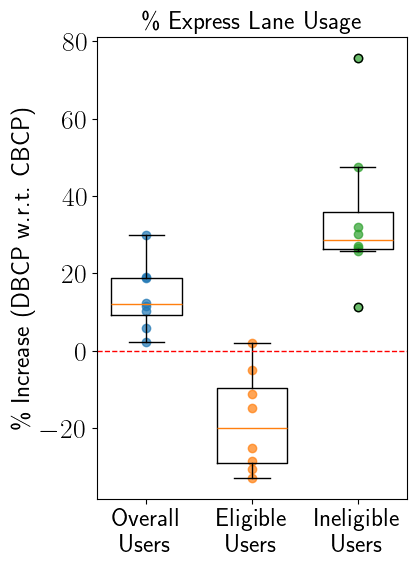

In [89]:
# Percent of express lane occupancy (lambda R \geq lambda_E)

percent_express_overall___lambda_R_geq_lambda_E = percent_express_lane_usage_rel_data_array___lambda_R_geq_lambda_E[:, 0]
percent_express_eligible___lambda_R_geq_lambda_E = percent_express_lane_usage_rel_data_array___lambda_R_geq_lambda_E[:, 1]
percent_express_ineligible___lambda_R_geq_lambda_E = percent_express_lane_usage_rel_data_array___lambda_R_geq_lambda_E[:, 2]

data = [percent_express_overall___lambda_R_geq_lambda_E,\
        percent_express_eligible___lambda_R_geq_lambda_E,\
        percent_express_ineligible___lambda_R_geq_lambda_E]
positions = np.array([1, 2, 3]) * 0.15

# plt.figure(figsize=(8, 5))
plt.figure(figsize=(4, 6))

# Boxplots
plt.boxplot(data, positions=positions, widths=0.1)

# Scatter points with jitter
for i, d in enumerate(data):
    # x_vals = np.random.normal(positions[i], 0.05, size=len(d))
    x_vals = positions[i] * np.ones(len(d)) 
    plt.scatter(x_vals, d, alpha=0.7)

# Set shared axis labels and ticks
plt.xticks(positions, ['Overall\nUsers', 'Eligible\nUsers', 'Ineligible\nUsers'], fontsize=18)
plt.yticks(fontsize=20)
plt.ylabel("\% Increase (DBCP w.r.t. CBCP)", fontsize=18)
# plt.ylabel("Magnitude")

# plt.xlim(positions[0], positions[-1])
pad = 0.07
plt.xlim(positions[0] - pad, positions[-1] + pad)

plt.axhline(y=0, color='red', linestyle='--', linewidth=1)

plt.title("\% Express Lane Usage", fontsize=18)
# plt.tick_params(axis='x', pad=2)
# plt.margins(x=0)

# plt.tight_layout()
# plt.subplots_adjust(wspace=0.5)
# plt.subplots_adjust(hspace=0.5)
plt.show()

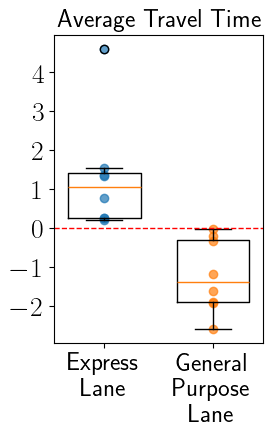

In [110]:
# Average travel time (lambda R \geq lambda_E)

avg_time_express___lambda_R_geq_lambda_E = average_travel_time_rel_data_array___lambda_R_geq_lambda_E[:, 0]
avg_time_gp____lambda_R_geq_lambda_E = average_travel_time_rel_data_array___lambda_R_geq_lambda_E[:, 1]

data = [avg_time_express___lambda_R_geq_lambda_E,\
        avg_time_gp____lambda_R_geq_lambda_E]
positions = np.array([1, 2]) * 0.15

# plt.figure(figsize=(8, 5))
plt.figure(figsize=(2.7, 4))

# Boxplots
plt.boxplot(data, positions=positions, widths=0.1)

# Scatter points with jitter
for i, d in enumerate(data):
    # x_vals = np.random.normal(positions[i], 0.05, size=len(d))
    x_vals = positions[i] * np.ones(len(d)) 
    plt.scatter(x_vals, d, alpha=0.7)

# Set shared axis labels and ticks
plt.xticks(positions, ['Express\nLane', 'General\nPurpose\nLane'], fontsize=18)
plt.yticks(fontsize=20)
# plt.ylabel("\% Increase (DBCP w.r.t. CBCP)", fontsize=20)
# plt.ylabel("Magnitude")

# plt.xlim(positions[0], positions[-1])
pad = 0.07
plt.xlim(positions[0] - pad, positions[-1] + pad)

plt.axhline(y=0, color='red', linestyle='--', linewidth=1)

plt.title("Average Travel Time", fontsize=18)
# plt.tick_params(axis='x', pad=2)
# plt.margins(x=0)

# plt.tight_layout()
# plt.subplots_adjust(wspace=0.5)
# plt.subplots_adjust(hspace=0.5)
plt.show()


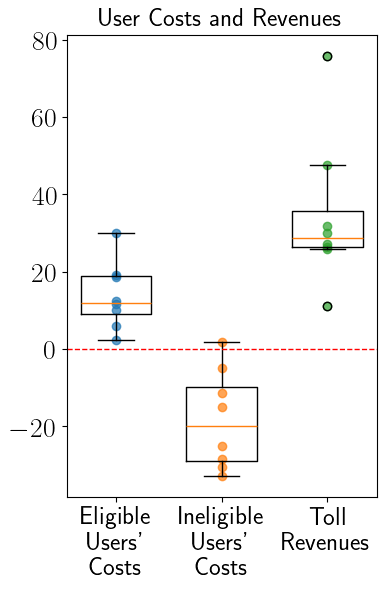

In [93]:
# # User Costs and Toll Revenues (lambda R \geq lambda_E)

eligible_user_costs___lambda_R_geq_lambda_E = user_costs_revenues_rel_data_array___lambda_R_geq_lambda_E[:, 0]
ineligible_user_costs___lambda_R_geq_lambda_E = user_costs_revenues_rel_data_array___lambda_R_geq_lambda_E[:, 1]
toll_revenues___lambda_R_geq_lambda_E = user_costs_revenues_rel_data_array___lambda_R_geq_lambda_E[:, 2]

data = [percent_express_overall___lambda_R_geq_lambda_E,\
        percent_express_eligible___lambda_R_geq_lambda_E,\
        percent_express_ineligible___lambda_R_geq_lambda_E]
positions = np.array([1, 2, 3]) * 0.15

# plt.figure(figsize=(8, 5))
plt.figure(figsize=(4, 6))

# Boxplots
plt.boxplot(data, positions=positions, widths=0.1)

# Scatter points with jitter
for i, d in enumerate(data):
    # x_vals = np.random.normal(positions[i], 0.05, size=len(d))
    x_vals = positions[i] * np.ones(len(d)) 
    plt.scatter(x_vals, d, alpha=0.7)

# Set shared axis labels and ticks
plt.xticks(positions, ['Eligible\nUsers\'\nCosts', 'Ineligible\nUsers\'\nCosts', 'Toll\nRevenues'], fontsize=18)
plt.yticks(fontsize=20)
# plt.ylabel("\% Increase (DBCP w.r.t. CBCP)", fontsize=16)
# plt.ylabel("Magnitude")

# plt.xlim(positions[0], positions[-1])
pad = 0.07
plt.xlim(positions[0] - pad, positions[-1] + pad)

plt.axhline(y=0, color='red', linestyle='--', linewidth=1)

plt.title("User Costs and Toll Revenues", fontsize=18)
# plt.tick_params(axis='x', pad=2)
# plt.margins(x=0)

# plt.tight_layout()
# plt.subplots_adjust(wspace=0.5)
# plt.subplots_adjust(hspace=0.5)
plt.show()


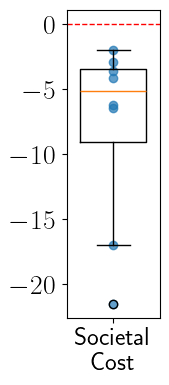

In [117]:
# Societal Cost (lambda R \geq lambda_E)

data = [societal_costs_rel_data_array___lambda_R_geq_lambda_E]
positions = np.array([1]) * 0.15

# plt.figure(figsize=(8, 5))
plt.figure(figsize=(1.2, 4))

# Boxplots
plt.boxplot(data, positions=positions, widths=0.1)

# Scatter points with jitter
for i, d in enumerate(data):
    # x_vals = np.random.normal(positions[i], 0.05, size=len(d))
    x_vals = positions[i] * np.ones(len(d)) 
    plt.scatter(x_vals, d, alpha=0.7)

# Set shared axis labels and ticks
plt.xticks(positions, ['Societal\nCost'], fontsize=18)
plt.yticks(fontsize=20)
# plt.ylabel("\% Increase (DBCP w.r.t. CBCP)", fontsize=20)
# plt.ylabel("Magnitude")

# plt.xlim(positions[0], positions[-1])
pad = 0.07
plt.xlim(positions[0] - pad, positions[-1] + pad)

plt.axhline(y=0, color='red', linestyle='--', linewidth=1)

# plt.title("Societal Cost", fontsize=18)
# plt.tick_params(axis='x', pad=2)
# plt.margins(x=0)

# plt.tight_layout()
# plt.subplots_adjust(wspace=0.5)
# plt.subplots_adjust(hspace=0.5)
plt.show()




## Generating Box Plots for lambda R less than lambda E

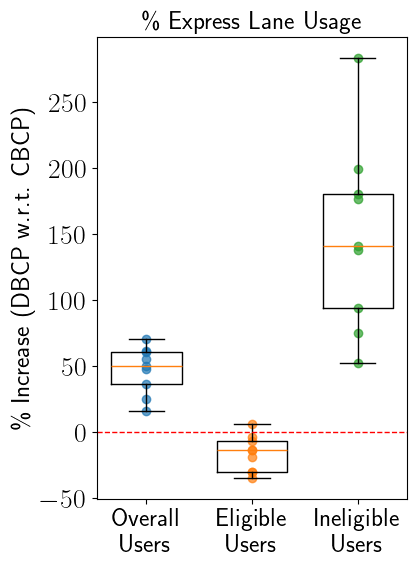

In [99]:
# Percent of express lane occupancy (lambda R < lambda_E)

percent_express_overall___lambda_R_less_than_lambda_E = percent_express_lane_usage_rel_data_array___lambda_R_less_than_lambda_E[:, 0]
percent_express_eligible___lambda_R_less_than_lambda_E = percent_express_lane_usage_rel_data_array___lambda_R_less_than_lambda_E[:, 1]
percent_express_ineligible___lambda_R_less_than_lambda_E = percent_express_lane_usage_rel_data_array___lambda_R_less_than_lambda_E[:, 2]

data = [percent_express_overall___lambda_R_less_than_lambda_E,\
        percent_express_eligible___lambda_R_less_than_lambda_E,\
        percent_express_ineligible___lambda_R_less_than_lambda_E]
positions = np.array([1, 2, 3]) * 0.15

# plt.figure(figsize=(8, 5))
plt.figure(figsize=(4, 6))

# Boxplots
plt.boxplot(data, positions=positions, widths=0.1)

# Scatter points with jitter
for i, d in enumerate(data):
    # x_vals = np.random.normal(positions[i], 0.05, size=len(d))
    x_vals = positions[i] * np.ones(len(d)) 
    plt.scatter(x_vals, d, alpha=0.7)

# Set shared axis labels and ticks
plt.xticks(positions, ['Overall\nUsers', 'Eligible\nUsers', 'Ineligible\nUsers'], fontsize=18)
plt.yticks(fontsize=20)
plt.ylabel("\% Increase (DBCP w.r.t. CBCP)", fontsize=18)
# plt.ylabel("Magnitude")

# plt.xlim(positions[0], positions[-1])
pad = 0.07
plt.xlim(positions[0] - pad, positions[-1] + pad)

plt.axhline(y=0, color='red', linestyle='--', linewidth=1)

plt.title("\% Express Lane Usage", fontsize=18)
# plt.tick_params(axis='x', pad=2)
# plt.margins(x=0)

# plt.tight_layout()
# plt.subplots_adjust(wspace=0.5)
# plt.subplots_adjust(hspace=0.5)
plt.show()

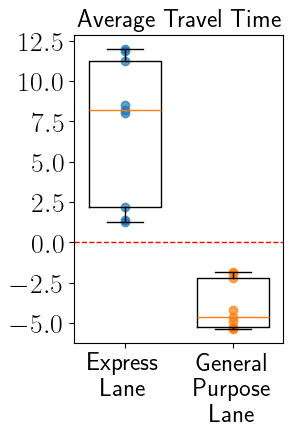

In [112]:
# Average travel time (lambda R < lambda_E)

avg_time_express___lambda_R_less_than_lambda_E = average_travel_time_rel_data_array___lambda_R_less_than_lambda_E[:, 0]
avg_time_gp____lambda_R_less_than_lambda_E = average_travel_time_rel_data_array___lambda_R_less_than_lambda_E[:, 1]

data = [avg_time_express___lambda_R_less_than_lambda_E,\
        avg_time_gp____lambda_R_less_than_lambda_E]
positions = np.array([1, 2]) * 0.15

# plt.figure(figsize=(8, 5))
plt.figure(figsize=(2.7, 4))

# Boxplots
plt.boxplot(data, positions=positions, widths=0.1)

# Scatter points with jitter
for i, d in enumerate(data):
    # x_vals = np.random.normal(positions[i], 0.05, size=len(d))
    x_vals = positions[i] * np.ones(len(d)) 
    plt.scatter(x_vals, d, alpha=0.7)

# Set shared axis labels and ticks
plt.xticks(positions, ['Express\nLane', 'General\nPurpose\nLane'], fontsize=18)
plt.yticks(fontsize=20)
# plt.ylabel("\% Increase (DBCP w.r.t. CBCP)", fontsize=20)
# plt.ylabel("Magnitude")

# plt.xlim(positions[0], positions[-1])
pad = 0.07
plt.xlim(positions[0] - pad, positions[-1] + pad)

plt.axhline(y=0, color='red', linestyle='--', linewidth=1)

plt.title("Average Travel Time", fontsize=18)
# plt.tick_params(axis='x', pad=2)
# plt.margins(x=0)

# plt.tight_layout()
# plt.subplots_adjust(wspace=0.5)
# plt.subplots_adjust(hspace=0.5)
plt.show()


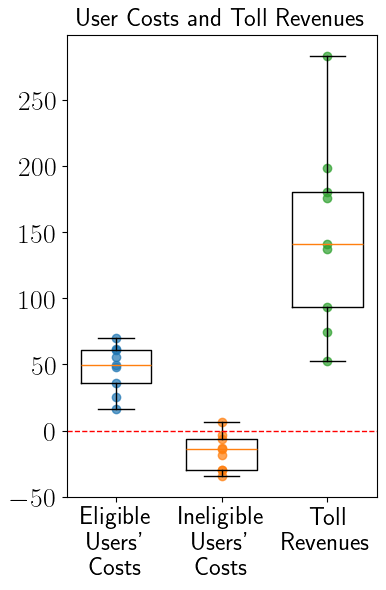

In [102]:
# # User Costs and Toll Revenues (lambda R < lambda_E)

eligible_user_costs___lambda_R_less_than_lambda_E = user_costs_revenues_rel_data_array___lambda_R_less_than_lambda_E[:, 0]
ineligible_user_costs___lambda_R_less_than_lambda_E = user_costs_revenues_rel_data_array___lambda_R_less_than_lambda_E[:, 1]
toll_revenues___lambda_R_less_than_lambda_E = user_costs_revenues_rel_data_array___lambda_R_less_than_lambda_E[:, 2]

data = [percent_express_overall___lambda_R_less_than_lambda_E,\
        percent_express_eligible___lambda_R_less_than_lambda_E,\
        percent_express_ineligible___lambda_R_less_than_lambda_E]
positions = np.array([1, 2, 3]) * 0.15

# plt.figure(figsize=(8, 5))
plt.figure(figsize=(4, 6))

# Boxplots
plt.boxplot(data, positions=positions, widths=0.1)

# Scatter points with jitter
for i, d in enumerate(data):
    # x_vals = np.random.normal(positions[i], 0.05, size=len(d))
    x_vals = positions[i] * np.ones(len(d)) 
    plt.scatter(x_vals, d, alpha=0.7)

# Set shared axis labels and ticks
plt.xticks(positions, ['Eligible\nUsers\'\nCosts', 'Ineligible\nUsers\'\nCosts', 'Toll\nRevenues'], fontsize=18)
plt.yticks(fontsize=20)
# plt.ylabel("\% Increase (DBCP w.r.t. CBCP)", fontsize=16)
# plt.ylabel("Magnitude")

# plt.xlim(positions[0], positions[-1])
pad = 0.07
plt.xlim(positions[0] - pad, positions[-1] + pad)

plt.axhline(y=0, color='red', linestyle='--', linewidth=1)

plt.title("User Costs and Toll Revenues", fontsize=18)
# plt.tick_params(axis='x', pad=2)
# plt.margins(x=0)

# plt.tight_layout()
# plt.subplots_adjust(wspace=0.5)
# plt.subplots_adjust(hspace=0.5)
plt.show()


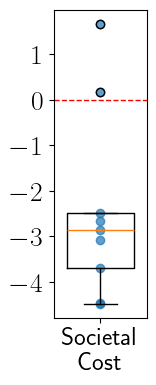

In [116]:
# Societal Cost (lambda R < lambda_E)

data = [societal_costs_rel_data_array___lambda_R_less_than_lambda_E]
positions = np.array([1]) * 0.15

# plt.figure(figsize=(8, 5))
plt.figure(figsize=(1.2, 4))

# Boxplots
plt.boxplot(data, positions=positions, widths=0.1)

# Scatter points with jitter
for i, d in enumerate(data):
    # x_vals = np.random.normal(positions[i], 0.05, size=len(d))
    x_vals = positions[i] * np.ones(len(d)) 
    plt.scatter(x_vals, d, alpha=0.7)

# Set shared axis labels and ticks
plt.xticks(positions, ['Societal\nCost'], fontsize=18)
plt.yticks(fontsize=20)
# plt.ylabel("\% Increase (DBCP w.r.t. CBCP)", fontsize=20)
# plt.ylabel("Magnitude")

# plt.xlim(positions[0], positions[-1])
pad = 0.07
plt.xlim(positions[0] - pad, positions[-1] + pad)

plt.axhline(y=0, color='red', linestyle='--', linewidth=1)

# plt.title("Societal Cost", fontsize=18)
# plt.tick_params(axis='x', pad=2)
# plt.margins(x=0)

# plt.tight_layout()
# plt.subplots_adjust(wspace=0.5)
# plt.subplots_adjust(hspace=0.5)
plt.show()




In [38]:
# column_names = []
# column_names += ["lambda_E", "lambda_R", "lambda_I"]
# column_names += ["% overall users using express lanes", \
#                  "% eligible users using express lanes", \
#                  "% ineligible users using express lanes", \
#                  "Average travel time (express lanes)", \
#                  "Average travel time (general purpose lanes)", \
#                  "Total travel cost (eligible users)", \
#                  "Total travel cost (ineligible users)", \
#                  "Total toll revenue"]

# df_stats_compare_to_save = pd.DataFrame(stats_compare_percentage_array, index=None, columns=column_names)

# df_stats_compare_to_save

In [39]:
# # directory_to_save = "../data/stats_compare/"
# # filename = "opt_CBCP_params___" + random_string + '.csv'

# filename = 'compare_stats___' + str(num_el) + '_el_groups.csv'

# df_stats_compare_to_save.to_csv(directory_to_save + filename)

# Generate Scatter Plot

In [40]:
stats_compare_absolute_percentage_array

array([[ 1.0000e+00,  1.0000e+00,  1.0000e+00,  0.0000e+00,  4.9600e+00,
        -1.3660e+01,  8.7300e+00,  9.8000e-01, -6.5000e-01,  4.4932e+02,
        -1.8800e+04, -2.2300e+03, -1.6100e+04],
       [ 1.0000e+00,  1.0000e+00,  1.0000e+00,  1.0000e+00,  2.9940e+01,
        -3.2820e+01,  7.5830e+01,  4.6000e+00, -2.6000e+00,  3.5100e+00,
        -2.3500e+00, -9.8600e+00, -2.0400e+00],
       [ 1.0000e+00,  5.0000e+00,  1.0000e+00,  0.0000e+00,  3.0500e+00,
         6.2000e-01,  3.5500e+00,  2.8000e-01, -4.9000e-01,  2.0003e+02,
        -1.3700e+04,  1.3900e+03, -2.0500e+04],
       [ 1.0000e+00,  5.0000e+00,  1.0000e+00,  1.0000e+00,  1.8690e+01,
         1.9000e+00,  2.7160e+01,  1.3200e+00, -1.9400e+00,  1.5300e+00,
        -1.7100e+00,  5.2600e+00, -2.9900e+00],
       [ 1.0000e+00,  1.0000e+01,  1.0000e+00,  0.0000e+00,  4.0000e-01,
        -6.8300e+00,  1.8600e+00,  4.0000e-02, -1.0000e-02,  2.5746e+02,
        -6.3100e+02,  1.6700e+03, -1.7100e+04],
       [ 1.0000e+00,  1.0000e+

# <font color='red'>STOP, END here. </font> 

# <font color='red'>End of Code to run.</font> 

# End of code to run.

# Sample Code, Generating Box Plots

In [45]:
# # Example data lists
# data1 = [5, 6, 7, 8, 10]
# data2 = [2, 3, 5, 4, 6]
# data3 = [8, 9, 11, 10, 12]

# data = [data1, data2, data3]

# # X positions for each scatter+box group
# positions = [1, 2, 3]

# fig, ax = plt.subplots(figsize=(8, 5))

# # Create boxplots
# ax.boxplot(data, positions=positions, widths=0.2)

# # Add scatter points
# for i, d in enumerate(data):
#     # x_vals = np.random.normal(positions[i], 0.05, size=len(d))  
#     x_vals = positions[i] * np.ones(len(d)) 
#     ax.scatter(x_vals, d, alpha=0.7)

# # Shared y-axis → Matplotlib does this automatically
# # but you can force specific magnitude limits if needed:
# # ax.set_ylim(min(min(data1), min(data2), min(data3)),
# #             max(max(data1), max(data2), max(data3)))

# ax.set_xticks(positions)
# ax.set_xticklabels(['Data 1', 'Data 2', 'Data 3'])
# ax.set_ylabel("Magnitude")
# ax.set_title("Scatter + Box Plots with Shared Magnitude Axis")

# plt.tight_layout()
# plt.show()

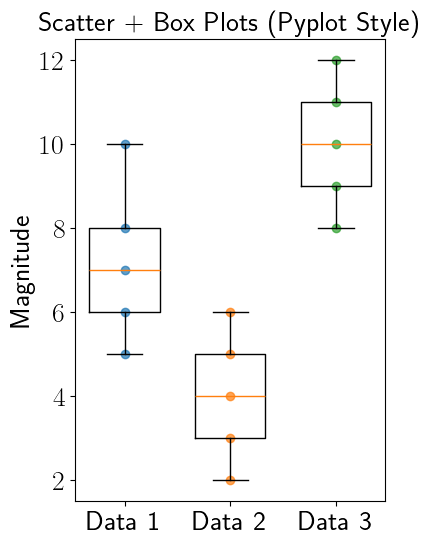

In [44]:
# Example data lists
data1 = [5, 6, 7, 8, 10]
data2 = [2, 3, 5, 4, 6]
data3 = [8, 9, 11, 10, 12]

data = [data1, data2, data3]
positions = np.array([1, 2, 3]) * 0.15

# plt.figure(figsize=(8, 5))
plt.figure(figsize=(4, 6))

# Boxplots
plt.boxplot(data, positions=positions, widths=0.1)

# Scatter points with jitter
for i, d in enumerate(data):
    # x_vals = np.random.normal(positions[i], 0.05, size=len(d))
    x_vals = positions[i] * np.ones(len(d)) 
    plt.scatter(x_vals, d, alpha=0.7)

# Set shared axis labels and ticks
plt.xticks(positions, ['Data 1', 'Data 2', 'Data 3'], fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel("Magnitude", fontsize=20)
# plt.ylabel("Magnitude")

# plt.xlim(positions[0], positions[-1])
pad = 0.07
plt.xlim(positions[0] - pad, positions[-1] + pad)

plt.title("Scatter + Box Plots (Pyplot Style)", fontsize=20)
# plt.tick_params(axis='x', pad=2)
# plt.margins(x=0)

# plt.tight_layout()
# plt.subplots_adjust(wspace=0.5)
# plt.subplots_adjust(hspace=0.5)
plt.show()

In [ ]:
# np.sum(np.array([1, 2, 3]) * np.array([5, 3, 1]))


In [ ]:
# avg_travel_time_CBCP_dict[(1.0, 1.0, 1.0)]

In [ ]:
# tau_CBCP_dict = {}
# tau_time_averaged_CBCP_dict = {}
# B_CBCP_dict = {}
# percent_express_lane_use_CBCP_dict = {}
# avg_travel_time_CBCP_dict = {}
# total_costs_CBCP_dict = {}

# tau_DBCP_dict = {}
# tau_time_averaged_DBCP_dict = {}
# alpha_DBCP_dict = {}
# percent_express_lane_use_DBCP_dict = {}
# avg_travel_time_DBCP_dict = {}
# total_costs_DBCP_dict = {}


# directory_CBCP = '../data/opt_CBCP_values___' + str(num_el) + '_el_groups/'
# directory_DBCP = '../data/opt_DBCP_values___' + str(num_el) + '_el_groups/'

# lambdas_index = 4
# lambda_E, lambda_R, lambda_I = lambdas_array[lambdas_index]
# lambdas = (lambda_E, lambda_R, lambda_I)
# filename_segment = str(int(lambda_E)) + '_' + str(int(lambda_R)) + '_' + str(int(lambda_I))

# # Inputting CBCP data:

# df_CBCP = pd.read_csv(directory_CBCP + filename_segment + '___tau_B_stats_CBCP.csv')
# tau_CBCP_dict[lambdas] = df_CBCP.to_numpy()[:, 1:6]
# tau_time_averaged_CBCP_dict[lambdas] = df_CBCP.to_numpy()[:, 6]
# B_CBCP_dict[lambdas] = df_CBCP.to_numpy()[0, 7]
# percent_express_lane_use_CBCP_dict[lambdas] = df_CBCP.to_numpy()[:, 8:11]
# avg_travel_time_CBCP_dict[lambdas] = df_CBCP.to_numpy()[:, 11:12]
# total_costs_CBCP_dict[lambdas] = df_CBCP.to_numpy()[:, 12:]

# # Inputting DBCP data:

# df_DBCP = pd.read_csv(directory_DBCP + filename_segment + '___tau_alpha_stats_DBCP.csv')
# tau_DBCP_dict[lambdas] = df_DBCP.to_numpy()[:, 1:6]
# tau_time_averaged_DBCP_dict[lambdas] = df_DBCP.to_numpy()[:, 6]
# alpha_DBCP_dict[lambdas] = df_DBCP.to_numpy()[:, 7:12]
# percent_express_lane_use_DBCP_dict[lambdas] = df_DBCP.to_numpy()[:, 12:15]
# avg_travel_time_DBCP_dict[lambdas] = df_DBCP.to_numpy()[:, 15:16]
# total_costs_DBCP_dict[lambdas] = df_DBCP.to_numpy()[:, 16:]



## Test:

## <font color='red'>Colored Font Titles</font> 

# Scratch Work:

In [ ]:
x = cp.Variable(2)
y = cp.Variable(2)
v_fixed = np.array([0, 1])
objective = cp.Minimize(cp.sum_squares(x - y) + cp.sum_squares(x - v_fixed))
constraints = []
prob = cp.Problem(objective, constraints)

# The optimal objective value is returned by `prob.solve()`.
result = prob.solve()
# The optimal value for x is stored in `x.value`.
print("x.value:", x.value)
print("y.value:", y.value)
print()


## Linear Approximation for Latency Function:

In [ ]:
# Variables:
v = cp.Variable(1)
            
# Objective:
func = v - 1 + cp.square(cp.maximum(v-1, 0))
objective = cp.Minimize(func)

# Constraints:
constraints = [-3.0 <= v, v <= 3.0]

# Solve problem:
prob = cp.Problem(objective, constraints)
result = prob.solve()

# Print solution:
print("v.value:", v.value)
